In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torchaudio
import numpy as np
from torchaudio import functional as F
from torchaudio.utils import download_asset
from IPython import display
import scipy.signal as ss
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from src.herb.algorithm import get_audio_hat, dereverberate
from src.LP.algotithm import LP_dereverberation

### Sample Data

In [2]:
SAMPLE_RIR = download_asset("tutorial-assets/Lab41-SRI-VOiCES-rm1-impulse-mc01-stu-clo-8000hz.wav")
SAMPLE_SPEECH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042-8000hz.wav")
sr = 16000

In [3]:
rir, rir_sr = torchaudio.load(SAMPLE_RIR)
rir = rir[:, int(rir_sr * 1.01) : int(rir_sr * 1.3)]
rir = rir / torch.linalg.vector_norm(rir, ord=2)
rir = torchaudio.transforms.Resample(rir_sr, sr)(rir)

display.Audio(rir, rate=sr)

In [4]:
speech, speech_sr = torchaudio.load(SAMPLE_SPEECH)
speech = torchaudio.transforms.Resample(speech_sr, sr)(speech)
display.Audio(speech, rate=sr)

In [5]:
augmented = F.fftconvolve(speech, rir)
display.Audio(augmented, rate=sr)

In [6]:
augmented = augmented.to(torch.float64).numpy().sum(axis=0)
augmented = augmented / np.abs(augmented).max()

#### Applying HERB

In [49]:
#result = get_audio_hat(augmented, augmented)
result,  spectr_filter = dereverberate(augmented, steps="full_filters")

In [42]:
result

array([ 0.00025934,  0.00027703,  0.00031551, ..., -0.00028859,
       -0.00029812, -0.00030109])

In [43]:
display.Audio(result / np.abs(result).max(), rate=sr)

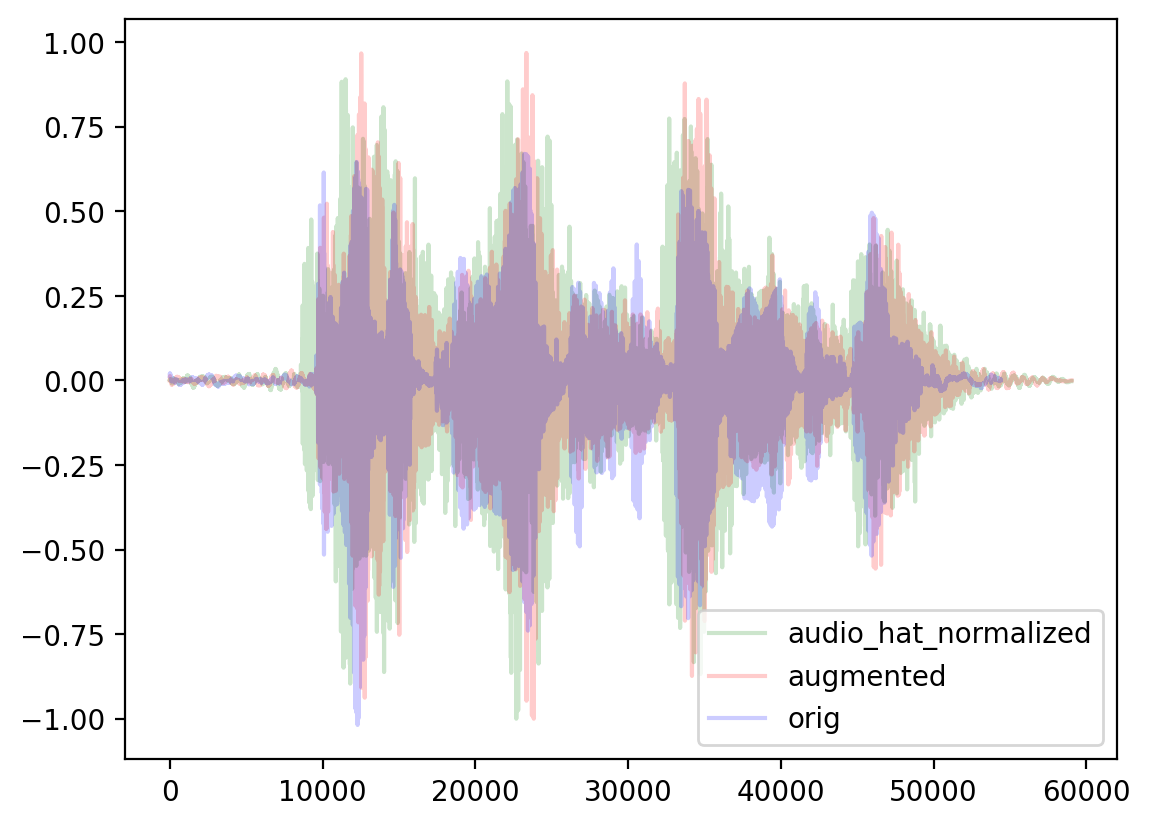

In [44]:
#plt.plot(result, color="blue", alpha=0.2, label="audio_hat")
plt.plot(result / np.abs(result).max(), color="green", alpha=0.2, label="audio_hat_normalized")
plt.plot(augmented, color="red", alpha=0.2, label="augmented")
plt.plot(speech[0].numpy(), color="blue", alpha=0.2, label="orig")
plt.legend()

##### T60

In [45]:
from pyroomacoustics.experimental.rt60 import measure_rt60

In [46]:
rir_numpy = rir[0].numpy()
rir_filtered = ss.convolve(rir_numpy, spectr_filter, mode="same")

(0.49925, 0.40112499999999995)

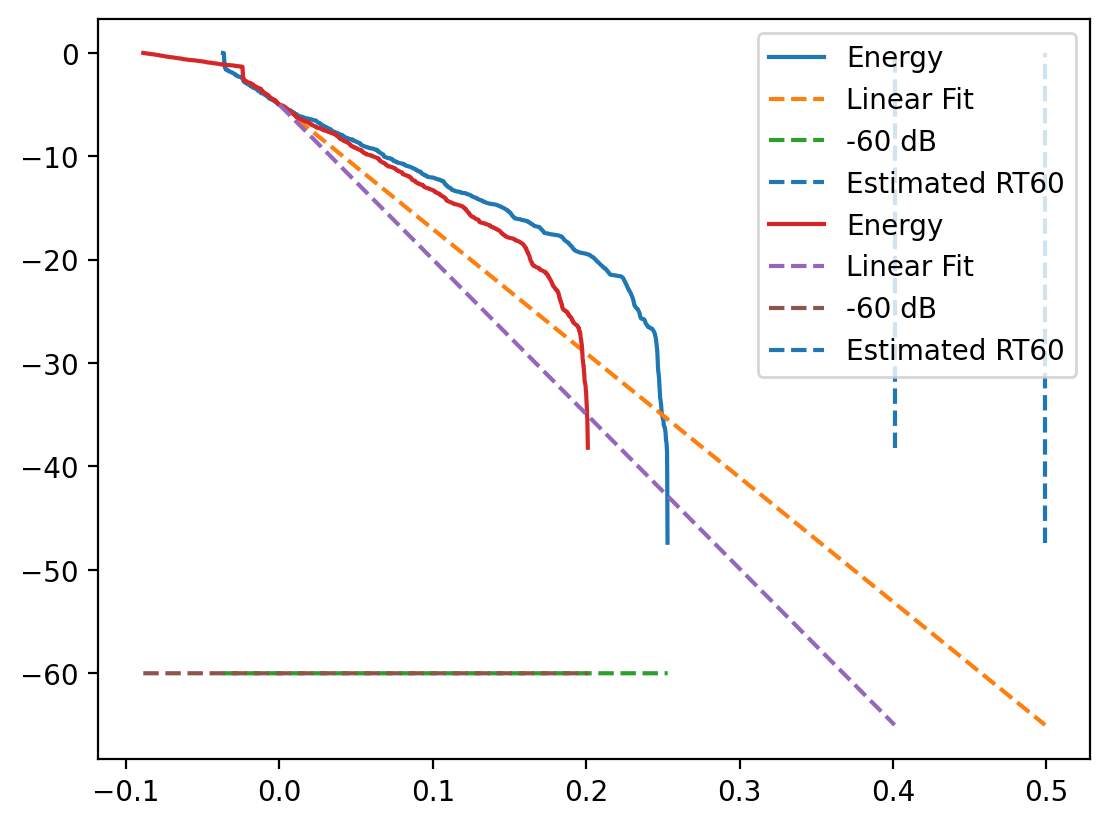

In [48]:
T60 = measure_rt60(rir_numpy, fs=16000, decay_db=30, plot=True)
filtered_T60 = measure_rt60(rir_filtered, fs=16000, decay_db=30, plot=True)

T60, filtered_T60

#### Applying LP


In [ ]:
Lp_derev, LP_filt = LP_dereverberation(augmented)